In [2]:
import pandas as pd
import numpy as np
import scipy
import re
import string

import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
from wordcloud import WordCloud


from sklearn.model_selection import train_test_split as split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgb

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer 
from nltk.stem import PorterStemmer, LancasterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from textblob import TextBlob
import warnings
warnings.filterwarnings('ignore') 

from IPython.display import Image

%matplotlib inline

# Womens Clothing E-Commerce Reviews - NLP

In [53]:
#Importing dataset
df = pd.read_csv("E-Commerce Reviews.csv", index_col=0)
print(df.shape)
df.head(3)

(23486, 10)


,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses


In [54]:
df.groupby(['Rating', 'Recommended IND'])['Recommended IND'].count()

Rating  Recommended IND
1       0                    826
        1                     16
2       0                   1471
        1                     94
3       0                   1682
        1                   1189
4       0                    168
        1                   4909
5       0                     25
        1                  13106
Name: Recommended IND, dtype: int64

In [55]:
df.loc[(df.Rating==5) & (df['Recommended IND']==0)]['Review Text'].iloc[1]

"This top is one of my retailer faves! it is so comfortable and love the quality and design. i receive many compliments on this top. i usually wear an xs or s in retailer tops and the xs was a little tight in the arms. the dressing room attendant suggested ordering a petite small so i wouldn't lose the shape. so glad i did. it fits perfect! i even ordered when it was on sale!! the gray color is perfect! its not too thick or thin."

In [56]:
#Keeping only the columns that has text features
text_df = df[['Title', 'Review Text', 'Recommended IND']]
text_df.head()

,Title,Review Text,Recommended IND
0,NaN,Absolutely wonderful - silky and sexy and comf...,1
1,NaN,Love this dress! it's sooo pretty. i happene...,1
2,Some major design flaws,I had such high hopes for this dress and reall...,0
3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",1
4,Flattering shirt,This shirt is very flattering to all due to th...,1


### Merging text features:

In [57]:
text_df['Review'] = text_df['Title'] + ' ' + text_df['Review Text']
text_df = text_df.drop(labels=['Title','Review Text'] , axis=1)
text_df.head()

,Recommended IND,Review
0,1,NaN
1,1,NaN
2,0,Some major design flaws I had such high hopes ...
3,1,"My favorite buy! I love, love, love this jumps..."
4,1,Flattering shirt This shirt is very flattering...


 ### Considering Non- null values:

In [58]:
text_df.Review.isna().sum()

3811

In [62]:

text_df = text_df[~text_df.Review.isna()]
text_df = text_df.rename(columns={"Recommended IND": "Recommended"})
print("My data's shape is:", text_df.shape)
text_df.head()

My data's shape is: (19675, 2)


,Recommended,Review
2,0,Some major design flaws I had such high hopes ...
3,1,"My favorite buy! I love, love, love this jumps..."
4,1,Flattering shirt This shirt is very flattering...
5,0,Not for the very petite I love tracy reese dre...
6,1,Cagrcoal shimmer fun I aded this in my basket ...


In [63]:
text_df['Recommended'].unique()

array([0, 1], dtype=int64)

In [64]:
#Calculating (after normalising) the unique recomended values
text_df['Recommended'].value_counts(normalize=True)

1    0.818297
0    0.181703
Name: Recommended, dtype: float64

### Adding Features

##### Text Length:

In [65]:
#Adding a column "Review_Length"
text_df['Review_length'] = text_df['Review'].apply(len)
print(text_df.shape)
text_df.head()

(19675, 3)


,Recommended,Review,Review_length
2,0,Some major design flaws I had such high hopes ...,524
3,1,"My favorite buy! I love, love, love this jumps...",141
4,1,Flattering shirt This shirt is very flattering...,209
5,0,Not for the very petite I love tracy reese dre...,512
6,1,Cagrcoal shimmer fun I aded this in my basket ...,517


In [66]:
text_df['Review_length'].describe()

count    19675.000000
mean       338.450267
std        144.740126
min         23.000000
25%        217.000000
50%        336.000000
75%        496.000000
max        557.000000
Name: Review_length, dtype: float64

In [67]:
df_zero = text_df[text_df['Recommended']==0]
df_one = text_df[text_df['Recommended']==1]

##### Exclamation mark counter:

In [68]:
#Function for counting number of exclaimation marks
def count_exclamation_mark(string_text):
    count = 0
    for char in string_text:
        if char == '!':
            count += 1
    return count

In [69]:
text_df['count_exc'] = text_df['Review'].apply(count_exclamation_mark)
text_df.head(5)

,Recommended,Review,Review_length,count_exc
2,0,Some major design flaws I had such high hopes ...,524,1
3,1,"My favorite buy! I love, love, love this jumps...",141,3
4,1,Flattering shirt This shirt is very flattering...,209,3
5,0,Not for the very petite I love tracy reese dre...,512,0
6,1,Cagrcoal shimmer fun I aded this in my basket ...,517,0


In [70]:
text_df['count_exc'].describe()

count    19675.000000
mean         0.883151
std          1.412098
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         41.000000
Name: count_exc, dtype: float64

In [73]:
#Checking indicies where count_exc =1
text_df[text_df['count_exc']== 1].index

Int64Index([    2,     9,    15,    19,    20,    22,    24,    29,    33,
               45,
            ...
            23459, 23460, 23465, 23467, 23471, 23473, 23478, 23479, 23481,
            23484],
           dtype='int64', length=4448)

In [74]:
text_df['Review'][23459]

"Perfect except slip This is my new favorite dress! my only complaint is the slip is too small and the dress cannot be worn without it. i can't order a size up as the dress would then be huge. not sure what the solution is but the dress itself is stunning."

##### Text Polarity

Polarity is the emotion expressed in the sentence. It can be positive, neagtive and neutral.

The polarity score is a float within the range [-1.0, 1.0]

In [75]:
text_df['Polarity'] = text_df['Review'].apply(lambda x: TextBlob(x).sentiment.polarity)
text_df.head(5)

,Recommended,Review,Review_length,count_exc,Polarity
2,0,Some major design flaws I had such high hopes ...,524,1,0.073209
3,1,"My favorite buy! I love, love, love this jumps...",141,3,0.560714
4,1,Flattering shirt This shirt is very flattering...,209,3,0.512891
5,0,Not for the very petite I love tracy reese dre...,512,0,0.181111
6,1,Cagrcoal shimmer fun I aded this in my basket ...,517,0,0.157500


In [76]:
text_prep = text_df.copy()

# Preprocessing - text features

### Dropping punctuation

In [77]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [78]:
#Function for dropping punctuations
def punctuation_removal(messy_str):
    clean_list = [char for char in messy_str if char not in string.punctuation]
    clean_str = ''.join(clean_list)
    return clean_str

In [79]:
text_prep['Review'] = text_prep['Review'].apply(punctuation_removal)
text_prep['Review'].head()

2    Some major design flaws I had such high hopes ...
3    My favorite buy I love love love this jumpsuit...
4    Flattering shirt This shirt is very flattering...
5    Not for the very petite I love tracy reese dre...
6    Cagrcoal shimmer fun I aded this in my basket ...
Name: Review, dtype: object

### Part of Speech filter:

Mostly adjectives and verbs reflect the positiveness or negativeness of the reviews

In [80]:
Image(url= "http://josecarilloforum.com/imgs/longnounphrase_schematic-1B.png", width=600, height=10)

In [81]:
#Collecting verbs and adjectives
def adj_collector(review_string):
    new_string=[]
    review_string = word_tokenize(review_string)
    tup_word = nltk.pos_tag(review_string)
    for tup in tup_word:
        if 'VB' in tup[1] or tup[1]=='JJ':  
            new_string.append(tup[0])  
    return ' '.join(new_string)

In [82]:
import nltk
nltk.download('punkt')
import nltk
nltk.download('averaged_perceptron_tagger')
text_prep['Review'] = text_prep['Review'].apply(adj_collector)
text_prep['Review'].head(7)

[nltk_data] Downloading package punkt to C:\Users\Dipanjana
[nltk_data]     Biswas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Dipanjana Biswas\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


2    major had such high wanted work i ordered smal...
3         favorite love love fabulous wear i get great
4    Flattering is flattering due adjustable is per...
5    petite love reese is petite am tall wear was i...
6    aded last see look i went am pale is gorgeous ...
7    goes ordered had try used top pair went is nic...
8    Flattering love get runs little ordered flatte...
Name: Review, dtype: object

**Description of Punkt Sentence Tokenizer** This tokenizer divides a text into a list of sentences, by using an unsupervised algorithm to build a model for abbreviation words, collocations, and words that start sentences. It must be trained on a large collection of plaintext in the target language before it can be used.

### Stopwords Removal

In [83]:
print(stopwords.words('english')[::12])

['i', "you'd", 'hers', 'which', 'were', 'a', 'at', 'above', 'again', 'both', 'own', "don't", 'aren', 'haven', "shan't"]


In [84]:
stop = stopwords.words('english')
stop.append("i'm")

In [85]:
stop_words = []

for item in stop: 
    new_item = punctuation_removal(item)
    stop_words.append(new_item) 
print(stop_words[::12])

['i', 'youd', 'hers', 'which', 'were', 'a', 'at', 'above', 'again', 'both', 'own', 'dont', 'aren', 'haven', 'shant']


Also adding clothing stopwords:

In [86]:
clothes_list =['dress', 'top','sweater','shirt',
               'skirt','material', 'white', 'black',
              'jeans', 'fabric', 'color','order', 'wear']

In [87]:
#Function for removing clothes stopworld
def stopwords_removal(messy_str):
    messy_str = word_tokenize(messy_str)
    return [word.lower() for word in messy_str 
            if word.lower() not in stop_words and word.lower() not in clothes_list ]

In [88]:
text_prep['Review'] = text_prep['Review'].apply(stopwords_removal)
text_prep['Review'].head()

2    [major, high, wanted, work, ordered, small, us...
3         [favorite, love, love, fabulous, get, great]
4    [flattering, flattering, due, adjustable, perf...
5    [petite, love, reese, petite, tall, long, full...
6    [aded, last, see, look, went, pale, gorgeous, ...
Name: Review, dtype: object

In [89]:
print(text_prep['Review'][3301])

['unique', 'received', 'artistic', 'casual', 'gorgeous', 'unique', 'runs', 'little', 'feel', 'enhances', 'appropriate', 'overall', 'ordered', 'usual', 'fits']


In [90]:
print(text_prep['Review'][267]) 

['nice', 'short', 'tall', 'iamp39d', 'say', 'fits', 'true', 'short', 'iamp39m', 'tall', 'wish', 'came']


### Removing all numbers (weight, size etc.)

In [91]:
def drop_numbers(list_text):
    list_text_new = []
    for i in list_text:
        if not re.search('\d', i):
            list_text_new.append(i)
    return ' '.join(list_text_new)

In [92]:
text_prep['Review'] = text_prep['Review'].apply(drop_numbers)
text_prep['Review'].head()

2    major high wanted work ordered small usual fou...
3                favorite love love fabulous get great
4    flattering flattering due adjustable perfect p...
5    petite love reese petite tall long full overwh...
6    aded last see look went pale gorgeous turns ma...
Name: Review, dtype: object

In [93]:
print(text_prep['Review'][267]) 

nice short tall say fits true short tall wish came


In [94]:
print(text_prep['Review'][2293])

flattering purchased return expected fit said lbs got get disappointed soft purchase regular fit looked terrible say tall thin yes short petite


### Stemming

In [95]:
porter = PorterStemmer()

In [96]:
text_prep['Review'] = text_prep['Review'].apply(lambda x: x.split())
text_prep['Review'].head()

2    [major, high, wanted, work, ordered, small, us...
3         [favorite, love, love, fabulous, get, great]
4    [flattering, flattering, due, adjustable, perf...
5    [petite, love, reese, petite, tall, long, full...
6    [aded, last, see, look, went, pale, gorgeous, ...
Name: Review, dtype: object

In [97]:
def stem_update(text_list):
    text_list_new = []
    for word in text_list:
        word = porter.stem(word)
        text_list_new.append(word) 
    return text_list_new

In [98]:
text_prep['Review'] = text_prep['Review'].apply(stem_update)
text_prep['Review'].head()

2    [major, high, want, work, order, small, usual,...
3             [favorit, love, love, fabul, get, great]
4    [flatter, flatter, due, adjust, perfect, pair,...
5    [petit, love, rees, petit, tall, long, full, o...
6    [ade, last, see, look, went, pale, gorgeou, tu...
Name: Review, dtype: object

In [99]:
text_prep['Review'] = text_prep['Review'].apply(lambda x: ' '.join(x))
text_prep['Review'].head()

2    major high want work order small usual found s...
3                    favorit love love fabul get great
4     flatter flatter due adjust perfect pair cardigan
5    petit love rees petit tall long full overwhelm...
6    ade last see look went pale gorgeou turn mathc...
Name: Review, dtype: object

In [100]:
print(text_prep['Review'][2293])

flatter purchas return expect fit said lb got get disappoint soft purchas regular fit look terribl say tall thin ye short petit


In [101]:
#Defining two dataframes for recomment = 1 and 0
pos_df = text_prep[text_prep.Recommended== 1]
neg_df = text_prep[text_prep.Recommended== 0]
pos_df.head(3)

,Recommended,Review,Review_length,count_exc,Polarity
3,1,favorit love love fabul get great,141,3,0.560714
4,1,flatter flatter due adjust perfect pair cardigan,209,3,0.512891
6,1,ade last see look went pale gorgeou turn mathc...,517,0,0.157500


In [102]:
pos_words =[]
neg_words = []

for review in pos_df.Review:
    pos_words.append(review) 
pos_words = ' '.join(pos_words)
pos_words[:40]

for review in neg_df.Review:
    neg_words.append(review)
neg_words = ' '.join(neg_words)
neg_words[:400]

'major high want work order small usual found small small zip reorder petit ok overal comfort fit bottom tight sever cheap imo major net c petit love rees petit tall long full overwhelm small shorten narrow take love work return look cheap run small run order fit tight cheap pull caus rip disappoint go say go look style side purchas knew larg next imposs second look cheap awkward tight look describ'

### Vectorizing - Bag of Words

In [103]:
text_prep['Review'].head()

2    major high want work order small usual found s...
3                    favorit love love fabul get great
4     flatter flatter due adjust perfect pair cardigan
5    petit love rees petit tall long full overwhelm...
6    ade last see look went pale gorgeou turn mathc...
Name: Review, dtype: object

In [104]:
def text_vectorizing_process(sentence_string):
    return [word for word in sentence_string.split()]

In [105]:
bow_transformer = CountVectorizer(text_vectorizing_process)

In [106]:
bow_transformer.fit(text_prep['Review'])

CountVectorizer(input=<function text_vectorizing_process at 0x000001E0FC43EB80>)

In [107]:
print(text_prep['Review'].iloc[5])

goe order tri use pair went nice went flare etc big go loos kept wil light sold


In [108]:
example = bow_transformer.transform([text_prep['Review'].iloc[5]])
print(example)
#3507=Love
#4438=petit

  (0, 558)	1
  (0, 1960)	1
  (0, 2233)	1
  (0, 2530)	1
  (0, 2535)	1
  (0, 3184)	1
  (0, 3364)	1
  (0, 3483)	1
  (0, 3961)	1
  (0, 4210)	1
  (0, 4318)	1
  (0, 5698)	1
  (0, 6508)	1
  (0, 6806)	1
  (0, 7038)	2
  (0, 7099)	1


In [109]:
Reviews = bow_transformer.transform(text_prep['Review'])
Reviews

<19675x7277 sparse matrix of type '<class 'numpy.int64'>'
	with 237960 stored elements in Compressed Sparse Row format>

In [110]:
print('Shape of Sparse Matrix', Reviews.shape)
print('Amount of Non-Zero occurences:', Reviews.nnz)

Shape of Sparse Matrix (19675, 7277)
Amount of Non-Zero occurences: 237960


# TF-IDF

Term Frequency–Inverse Document Frequency

In [111]:
tfidf_transformer = TfidfTransformer().fit(Reviews)

tfidf_example = tfidf_transformer.transform(example)
print (tfidf_example)
#3507=Love
#4438=petit

  (0, 7099)	0.4167427454376708
  (0, 7038)	0.39932067735983107
  (0, 6806)	0.23624321664553605
  (0, 6508)	0.14356316781797765
  (0, 5698)	0.24271765879383345
  (0, 4318)	0.2282888888923782
  (0, 4210)	0.13416789820124478
  (0, 3961)	0.14974249697911535
  (0, 3483)	0.19757369800246377
  (0, 3364)	0.20362399541945644
  (0, 3184)	0.2558118554959364
  (0, 2535)	0.23649105684594238
  (0, 2530)	0.15650819937169955
  (0, 2233)	0.2641113960879429
  (0, 1960)	0.3385049346514434
  (0, 558)	0.16821017023602194


In [112]:
[i for i in bow_transformer.vocabulary_.items() if i[1]==3505]

[('loungey', 3505)]

In [113]:
[i for i in bow_transformer.vocabulary_.items()][6:60:10]

[('usual', 6813),
 ('tight', 6383),
 ('flatter', 2243),
 ('overwhelm', 4302),
 ('pale', 4323),
 ('said', 5133)]

In [114]:
messages_tfidf = tfidf_transformer.transform(Reviews)
messages_tfidf.shape

(19675, 7277)

In [115]:
print(messages_tfidf[:1]) 
#tuple(index_num, word_num), tfidf_proba

  (0, 7273)	0.21472646647428087
  (0, 7159)	0.12712196996857394
  (0, 6930)	0.12017260570324308
  (0, 6813)	0.1513403250714934
  (0, 6383)	0.14060642619885752
  (0, 5601)	0.29785858576976637
  (0, 5290)	0.18845614450376966
  (0, 4943)	0.2444427546112772
  (0, 4438)	0.13986672876492434
  (0, 4260)	0.15858178150697497
  (0, 4210)	0.1001757163619286
  (0, 4138)	0.20901503445074096
  (0, 3944)	0.30397328049150685
  (0, 3584)	0.5250571838807988
  (0, 2934)	0.3111586573431781
  (0, 2769)	0.14606384138147635
  (0, 2364)	0.15056928107008546
  (0, 2197)	0.08515558755200825
  (0, 1153)	0.10625437706817653
  (0, 984)	0.19198542692781725
  (0, 698)	0.18408106529286453


### Merging Sparse matrix with other features

In [116]:
messages_tfidf = messages_tfidf.toarray()
messages_tfidf = pd.DataFrame(messages_tfidf)
print(messages_tfidf.shape)
messages_tfidf.head()

(19675, 7277)


,0,1,2,3,4,5,6,7,8,9,...,7267,7268,7269,7270,7271,7272,7273,7274,7275,7276
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.214726,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [117]:
df_all = pd.merge(text_prep.drop(columns='Review'),messages_tfidf, 
                  left_index=True, right_index=True )
df_all.head()

,Recommended,Review_length,count_exc,Polarity,0,1,2,3,4,5,...,7267,7268,7269,7270,7271,7272,7273,7274,7275,7276
2,0,524,1,0.073209,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,141,3,0.560714,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,209,3,0.512891,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,512,0,0.181111,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1,517,0,0.157500,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Splitting the data

In [118]:
X = df_all.drop('Recommended', axis=1)
y = df_all.Recommended

X.head()

,Review_length,count_exc,Polarity,0,1,2,3,4,5,6,...,7267,7268,7269,7270,7271,7272,7273,7274,7275,7276
2,524,1,0.073209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,141,3,0.560714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,209,3,0.512891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,512,0,0.181111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,517,0,0.157500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [119]:
X.shape

(16481, 7280)

In [120]:
X.describe()

,Review_length,count_exc,Polarity,0,1,2,3,4,5,6,...,7267,7268,7269,7270,7271,7272,7273,7274,7275,7276
count,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.0,16481.000000,16481.000000,16481.000000,...,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000
mean,338.411261,0.876221,0.265987,0.000024,0.000030,0.000024,0.0,0.000049,0.000021,0.000020,...,0.000023,0.000025,0.000076,0.000048,0.000054,0.000021,0.002118,0.000315,0.000030,0.000125
std,144.790275,1.414203,0.172803,0.003139,0.003794,0.003098,0.0,0.004483,0.002695,0.002549,...,0.002950,0.003207,0.004952,0.004398,0.004935,0.002727,0.027395,0.010892,0.003799,0.007291
min,23.000000,0.000000,-0.987500,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,217.000000,0.000000,0.158333,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,335.000000,0.000000,0.260863,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,497.000000,1.000000,0.370312,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,557.000000,41.000000,1.000000,0.402938,0.487124,0.397730,0.0,0.447529,0.345954,0.327234,...,0.378710,0.411733,0.382191,0.400114,0.496872,0.350060,0.629020,0.484828,0.487690,0.526867


In [121]:
X_train, X_test, y_train, y_test = split(X,y, test_size=0.3, stratify=y, random_state=111)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11536, 7280), (4945, 7280), (11536,), (4945,))

In [66]:
y_train.value_counts(normalize=True)

1    0.818741
0    0.181259
Name: Recommended, dtype: float64

In [67]:
y_test.value_counts(normalize=True)

1    0.818605
0    0.181395
Name: Recommended, dtype: float64

### Scaler - MinMaxScaler

Transform features by scaling each feature to a given range.

This estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.

In [68]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [69]:
pd.DataFrame(X_train_scaled,columns= X_train.columns).describe()

,Review_length,count_exc,Polarity,0,1,2,3,4,5,6,...,7267,7268,7269,7270,7271,7272,7273,7274,7275,7276
count,11536.000000,11536.000000,11536.000000,11536.000000,11536.000000,11536.000000,11536.0,11536.000000,11536.000000,11536.000000,...,11536.000000,11536.0,11536.000000,11536.000000,11536.000000,11536.000000,11536.000000,11536.000000,11536.0,11536.000000
mean,0.587341,0.021667,0.631576,0.000087,0.000087,0.000087,0.0,0.000087,0.000087,0.000087,...,0.000087,0.0,0.000285,0.000087,0.000155,0.000087,0.003269,0.000680,0.0,0.000340
std,0.272417,0.035310,0.087348,0.009310,0.009310,0.009310,0.0,0.009310,0.009310,0.009310,...,0.009310,0.0,0.015486,0.009310,0.011872,0.009310,0.043065,0.023211,0.0,0.016539
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,0.357678,0.000000,0.577737,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,0.578652,0.000000,0.628931,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
75%,0.885768,0.024390,0.683922,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,...,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000


### Data Visualization (PCA)

In [70]:
pca_transformer = PCA(n_components=2).fit(X_train_scaled)
X_train_scaled_pca = pca_transformer.transform(X_train_scaled)
X_test_scaled_pca = pca_transformer.transform(X_test_scaled)
X_train_scaled_pca[:1]

array([[-0.13600042, -0.04987566]])

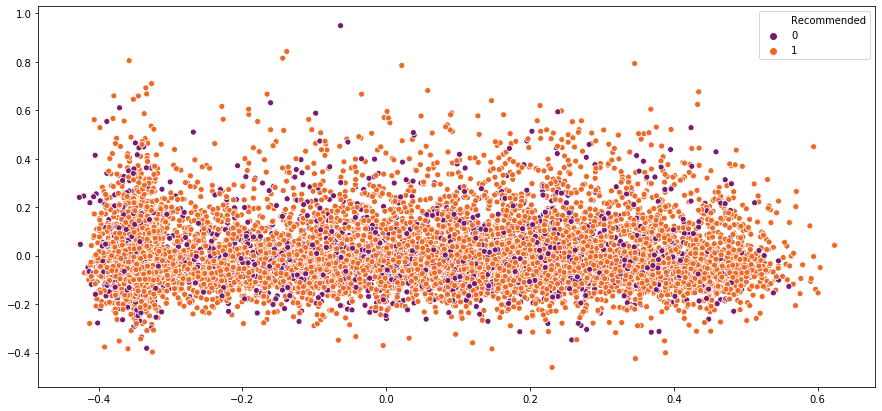

In [71]:
plt.figure(figsize=(15,7))
sns.scatterplot(x=X_train_scaled_pca[:, 0], 
                y=X_train_scaled_pca[:, 1], 
                hue=y_train, 
                sizes=100,
                palette="inferno") 

In [72]:
X_train_scaled = scipy.sparse.csr_matrix(X_train_scaled)
X_test_scaled = scipy.sparse.csr_matrix(X_test_scaled)

X_train = scipy.sparse.csr_matrix(X_train.values)
X_test = scipy.sparse.csr_matrix(X_test.values)
X_test

<4945x7280 sparse matrix of type '<class 'numpy.float64'>'
	with 71934 stored elements in Compressed Sparse Row format>

# Models

In [93]:
from sklearn.metrics import accuracy_score
def report(y_true, y_pred, labels):
    cm = pd.DataFrame(confusion_matrix(y_true=y_true, y_pred=y_pred), 
                                        index=labels, columns=labels)
    rep = classification_report(y_true=y_true, y_pred=y_pred)
    return (f'Confusion Matrix:\n{cm}\n\nClassification Report:\n{rep}')

Model Evaluation will be made by two metrics:
1. <u> F1 micro score</u>  - which is the harmonic mean of precision and recall, and takes into account label imbalances.
2. <u> AUC </u>- ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes.


# Multi-layer Perceptron classifier

In [95]:
from sklearn.neural_network import MLPClassifier
classifier = MLPClassifier()
classifier.fit(X_train,y_train)
y_pred1 = classifier.predict(X_test)
clf_accuracy=accuracy_score(y_test,y_pred1)
print("MLP Model accuracy",clf_accuracy)

MLP Model accuracy 0.8004044489383215


In [96]:
test_predictions = classifier.predict(X_test_scaled)
print(report(y_test, test_predictions, classifier.classes_ ))

Confusion Matrix:
     0     1
0   51   846
1  208  3840

Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.06      0.09       897
           1       0.82      0.95      0.88      4048

   micro avg       0.79      0.79      0.79      4945
   macro avg       0.51      0.50      0.48      4945
weighted avg       0.71      0.79      0.74      4945



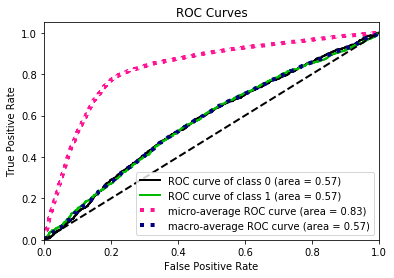

In [97]:
skplt.metrics.plot_roc(y_test, classifier.predict_proba(X_test_scaled)) 

# Logistic Regression Model

In [98]:
from sklearn.linear_model import LogisticRegressionCV
classifier=LogisticRegressionCV(cv=6,scoring='accuracy',random_state=0,n_jobs=-1,verbose=3,max_iter=500).fit(X_train,y_train)
y_pred1 = classifier.predict(X_test)
clf_accuracy=accuracy_score(y_test,y_pred1)
print("Logistic Regression Model accuracy",clf_accuracy)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Logistic Regression Model accuracy 0.8374115267947422


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   15.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   15.8s finished


In [99]:
test_predictions = classifier.predict(X_test_scaled)
print(report(y_test, test_predictions, classifier.classes_ ))

Confusion Matrix:
   0     1
0  0   897
1  0  4048

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       897
           1       0.82      1.00      0.90      4048

   micro avg       0.82      0.82      0.82      4945
   macro avg       0.41      0.50      0.45      4945
weighted avg       0.67      0.82      0.74      4945



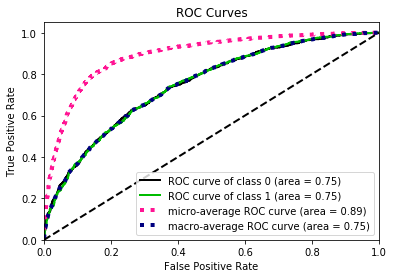

In [100]:
skplt.metrics.plot_roc(y_test, classifier.predict_proba(X_test_scaled)) 

# XGBoost Model

In [101]:
import xgboost as xgb
xgb=xgb.XGBClassifier()
xgb.fit(X_train,y_train)
preds2=xgb.predict(X_test)
xgb_accuracy=accuracy_score(y_test,preds2)
print("XGBoost Model accuracy",xgb_accuracy)

XGBoost Model accuracy 0.8386248736097067


In [102]:
test_predictions = classifier.predict(X_test_scaled)
print(report(y_test, test_predictions, classifier.classes_ ))

Confusion Matrix:
   0     1
0  0   897
1  0  4048

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       897
           1       0.82      1.00      0.90      4048

   micro avg       0.82      0.82      0.82      4945
   macro avg       0.41      0.50      0.45      4945
weighted avg       0.67      0.82      0.74      4945



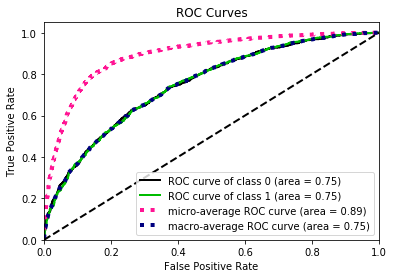

In [103]:
skplt.metrics.plot_roc(y_test, classifier.predict_proba(X_test_scaled)) 

# Random Forrest Model

In [104]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
classifier.fit(X_train,y_train)
preds=classifier.predict(X_test)
rf_accuracy=accuracy_score(preds,y_test)
print("Random Forest Model accuracy",rf_accuracy)

Random Forest Model accuracy 0.8135490394337714


In [105]:
test_predictions = classifier.predict(X_test_scaled)
print(report(y_test, test_predictions, classifier.classes_ ))

Confusion Matrix:
     0     1
0   56   841
1  212  3836

Classification Report:
              precision    recall  f1-score   support

           0       0.21      0.06      0.10       897
           1       0.82      0.95      0.88      4048

   micro avg       0.79      0.79      0.79      4945
   macro avg       0.51      0.51      0.49      4945
weighted avg       0.71      0.79      0.74      4945



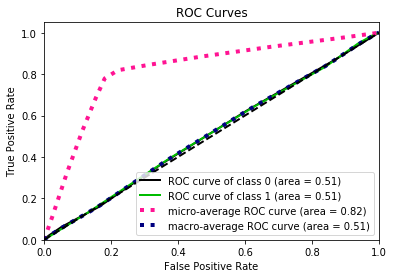

In [106]:
skplt.metrics.plot_roc(y_test, classifier.predict_proba(X_test_scaled)) 

# Bernoulli Naive Bayes

In [108]:
from sklearn.naive_bayes import BernoulliNB
classifier = BernoulliNB()
classifier.fit(X_train, y_train)
preds=classifier.predict(X_test)
rf_accuracy=accuracy_score(preds,y_test)
print("Bernouli NAive Bayes Model accuracy",rf_accuracy)

Bernouli NAive Bayes Model accuracy 0.8091001011122346


In [109]:
test_predictions = classifier.predict(X_test_scaled)
print(report(y_test, test_predictions, classifier.classes_ ))

Confusion Matrix:
     0     1
0   32   865
1  105  3943

Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.04      0.06       897
           1       0.82      0.97      0.89      4048

   micro avg       0.80      0.80      0.80      4945
   macro avg       0.53      0.50      0.48      4945
weighted avg       0.71      0.80      0.74      4945



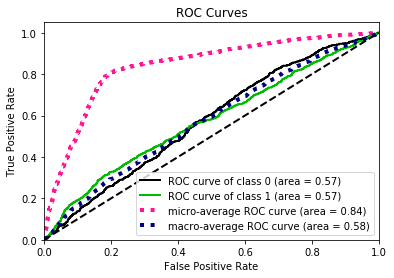

In [110]:
skplt.metrics.plot_roc(y_test, classifier.predict_proba(X_test_scaled)) 

# SVM

In [111]:
svc_model = SVC(C=1.0, 
             kernel='linear',
             class_weight='balanced', 
             probability=True,
             random_state=111)
svc_model.fit(X_train_scaled, y_train)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=111,
  shrinking=True, tol=0.001, verbose=False)

In [112]:
preds=svc_model.predict(X_test)
rf_accuracy=accuracy_score(preds,y_test)
print("Bernouli NAive Bayes Model accuracy",rf_accuracy)

Bernouli NAive Bayes Model accuracy 0.8186046511627907


In [113]:
test_predictions = svc_model.predict(X_test_scaled)
print(report(y_test, test_predictions, svc_model.classes_ ))

Confusion Matrix:
     0     1
0  517   380
1  995  3053

Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.58      0.43       897
           1       0.89      0.75      0.82      4048

   micro avg       0.72      0.72      0.72      4945
   macro avg       0.62      0.67      0.62      4945
weighted avg       0.79      0.72      0.75      4945



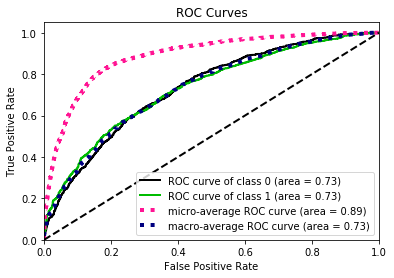

In [114]:
skplt.metrics.plot_roc(y_test, svc_model.predict_proba(X_test_scaled)) 

We have used 'Multi Layer Perceptron', 'Logistic Regression', 'XgBoost', 'Random Forest', 'Naive Bayes', and 'SVM'  because they prove to perform best for processing sentiment prediction based on text data

## Comaparison of accuracy of Above algorithms

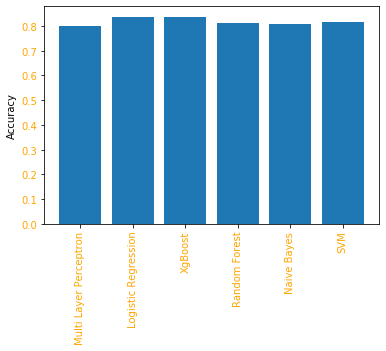

In [3]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
 
# Choose the height of the bars
accuracy = [.800, .837, .838, .813, .809, .818]
plt.ylabel("Accuracy")
 
# Choose the names of the bars
bars = ('Multi Layer Perceptron', 'Logistic Regression', 'XgBoost', 'Random Forest', 'Naive Bayes', 'SVM')
y_pos = np.arange(len(bars))
 
# Create bars
plt.bar(y_pos, accuracy)
 
# Create names on the x-axis
plt.xticks(y_pos, bars, color='orange', rotation=90)
plt.yticks(color='orange')
 
# Show graphic
plt.show()